<center><span style="font-size:34px; font-weight:bold">Econometrics Project</span><br></center>

<span><br></span>

<center style="font-size:18px">
    11510691 CHENG Yuanxing, 11510806 HU Xiaoyi, 11510810 HE Wanting
</center>

In our project we explore the relation between **commodity prices index** and the **CPI**.

We collect the time series of both indexes, explore the cointegration between them and finally discuss the implications.

In [1]:
# required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm
from arch.unitroot import PhillipsPerron

c:\program files\python35\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Get data

We use data of American monthly CPI index from year $1978$ to year $2017$. Here the **Consumer Price Index** research series using current methods (CPI-U-RS) presents an estimate of the **CPI** for all Urban Consumers (CPI-U) from $1978$ to present that incorporates most of the improvements made over that time span into the entire series.

In [2]:
# Use American monthly CPI index from year 1978 to year 2017, seasonally adjusted, available at 
# https://www.bls.gov/cpi/research-series/allitems.xlsx
rawdata = pd.read_excel('AmeriCPI.xlsx', sheetname=1, header = 6)
rawdata.head(4)

,YEAR,JAN,FEB,MAR,APR,MAY,JUNE,JULY,AUG,SEP,OCT,NOV,DEC,AVG
0,1977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.3,NaN
1,1978,100.8,101.3,101.8,102.7,103.6,104.2,104.7,105.3,106.1,106.7,107.4,108.2,104.4
2,1979,109.0,109.9,110.8,111.8,112.8,114.0,115.0,115.9,116.7,117.9,118.6,119.8,114.3
3,1980,121.2,122.6,123.8,124.6,125.6,126.4,127.4,128.5,129.8,130.6,131.7,132.5,127.0


As researched by *R.A. Pecchenino(1992)*, the CPI is considered cointegrated with the commodity price indices. Here we use the  Dow Jones Commodity Index as our data resources.

In [3]:
# The CPI is considered cointegrated with the commodity price indices, as researched by R.A. Pecchenino(1992)
rawdata2 = pd.read_excel('DJCI.xls', header = 6, skip_footer=129)
# TR: total return, ER: excess return
rawdata2.head()

,Effective date,Dow Jones Commodity Index TR,Dow Jones Commodity Index ER,Dow Jones Commodity Index
0,2008-05-30,562.18,410.73,682.15
1,2008-06-02,566.74,414.00,687.58
2,2008-06-03,559.74,408.86,679.04
3,2008-06-04,556.23,406.28,674.75
4,2008-06-05,567.26,414.32,688.11


In [4]:
rawdata2 = rawdata2.iloc[1:,[0,3]]
rawdata2.index = range(len(rawdata2))
# remove an additional space, and remave the last column
rawdata2.columns = ['Effective date','DJCI']
#resmaple the data by the time unit of months taking averge
resampled = rawdata2.resample('M', on='Effective date').mean()
data_array2 = np.ravel(resampled)

In [6]:
# The Dow Jones Commodity Index was recorded from 2018 the June, so we match the two
data_array1 = np.insert(rawdata.iloc[32:,1:13].values,0,rawdata.iloc[31,6:13])

# Stationary test

In [7]:
# Phillips Perron test
# http://arch.readthedocs.io/en/latest/unitroot/tests.html#phillips-perron-testing
pp1 = PhillipsPerron(data_array1)
pp1

Test Statistic,0.491
P-value,0.985
Lags,13


In [8]:
# 'nc' indicates no trend component in the test
pp1.trend = 'nc'
pp1

Test Statistic,3.512
P-value,1.000
Lags,13


In [9]:
pp2 = PhillipsPerron(data_array2)
pp2

Test Statistic,-1.969
P-value,0.301
Lags,13


In [10]:
# 'ct' indicates a constant and linear time trend in the test
pp2.trend = 'ct'
pp2

Test Statistic,-1.950
P-value,0.628
Lags,13


The *null hypothesis* of the **Phillips-Perron test** is that there is a unit root, with the *alternative* that there is no unit root. If the $p$ value is above a critical size, then the null cannot be rejected that there and the series appears to be a unit root. So here we can't reject the *null* and thus, it's *unstationary*.

# Cointegration test and stationary test on the spread

Here we intend to run the regression:

$$\text{Commodity price index}_t = \alpha + \beta CPI_t +\delta_1 \Delta CPI_{t-1} + \delta_2 \Delta CPI_{t-2} + \gamma_1 \Delta CPI_{t+1}+ \gamma_2 \Delta CPI_{t+2}+e_t $$

In [11]:
regression_data2 = data_array2[5:]
regression_data1 = data_array1[5:]
delta_data_array1 = data_array1[:-1] - data_array1[1:]
delta_tp2 = delta_data_array1[4:]
delta_tp1 = delta_data_array1[3:-1]
delta_tm1 = delta_data_array1[1:-3]
delta_tm2 = delta_data_array1[:-4]

In [12]:
# Find the cointgration parameter
regression_matrix = sm.add_constant(np.array([regression_data1,delta_tm1,delta_tm2,delta_tp1,delta_tp2]).T)
model = sm.OLS(regression_data2,regression_matrix)
results = model.fit()

In [13]:
# coefficients: alpha, beta, detla_1, delta_2, gamma_1, gamma_2
results.params

array([978.27893045,  -1.1649586 , -27.56662999, -29.45654111,
       -31.77281647, -19.26055131])

$$\begin{array}{cc} \hline
\text{parameter}&\text{value}\\ \hline
\alpha & 978.27893045 \\
\beta & -1.1649586\\
\delta_1 & -27.56662999\\
\delta_2 &  -29.45654111\\
\gamma_1 & -31.77281647\\
\gamma_2 & -19.2605513\\ \hline
\end{array}$$

In [14]:
beta = results.params[1]

Cointegration is defined as following: If $\{y_t: t = 0,1,...\}$ and $\{x_t: t=0,1,...\}$ are two $I(1)$ processes, then, in general, $y_t - \beta x_t$ is an $I(1)$ process for any number $\beta$. Nevertheless, it is *possible* that for some $\beta \neq 0$, $y_t - \beta x_t$ is an $I(0)$ process, which means it has constant mean, constant variance, and autocorrelations that depend only on the time distance between two variables. If such a $\beta$ exists, we say that $y$ and $x$ are **cointegrated**, and we call $\beta$ the cointegration parameter.  
So now we compute the new series spread 

$$\text{spread}_t = \text{Commodity price index}_t - \beta \text{CPI}_t $$

In [15]:
# Phipplip Perron test on the spread
spread = data_array2 - beta*data_array1
pp3 = PhillipsPerron(spread)
pp3

Test Statistic,-1.969
P-value,0.300
Lags,13


In [16]:
# 'ct' indicates a constant and linear time trend in the test
pp3.trend = 'ct'
pp3

Test Statistic,-1.970
P-value,0.617
Lags,13


According to the p-value, we cannot reject the null hypothesis that the process contains a unit root. If two series are cointegrated, this should be an $I(0)$ process, this is a contradiction, so two series are not integrated.

# Include the spread, the ECM

As $x_t$ and $y_t$ are $I(1)$ processes and are *not* integrated, we might estimate a model in first differences. The term $\delta(y_{t-1}-\beta x_{t-1})$ is called the *error correction term*, we can introduce its lag into the model and comstruct an error collection model. An error correction model allows us to study the short-run dynamics in the relationship between $x$ and $y$.

In [17]:
demeaned_spread = spread - np.mean(spread)
demeaned_spread = demeaned_spread[5:]

In [18]:
ECM_regression_data2 = data_array2[5:] - data_array2[4:-1]
ECM_delta2_tm1 = data_array2[4:-1] - data_array2[3:-2]
ECM_regression_matrix = np.array([demeaned_spread,ECM_delta2_tm1,delta_tm1]).T
ECM_model = sm.OLS(ECM_regression_data2,ECM_regression_matrix)
ECM_results = ECM_model.fit()

In [19]:
# coefficients: theta_0, theta_1, theta_2
ECM_results.params

array([-0.00329482,  0.34211161,  0.54969131])

# Plot

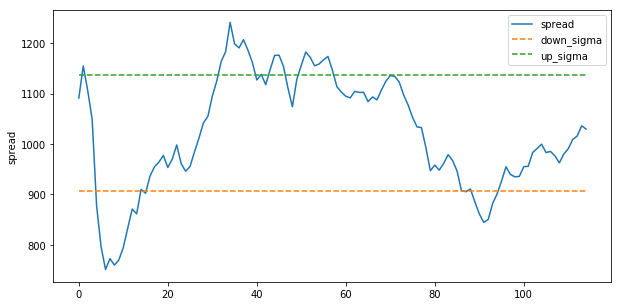

In [20]:
fig = plt.figure()
fig.set_size_inches(10,5)
ax = fig.add_subplot(111)
A = ax.plot(spread,label='spread')
unit = np.ones_like(spread)
up_sigma = np.mean(spread) + np.std(spread)
up_sigma = up_sigma*unit
down_sigma = np.mean(spread) - np.std(spread)
down_sigma = down_sigma*unit
B = ax.plot(down_sigma,'--',label='down_sigma')
C = ax.plot(up_sigma,'--',label='up_sigma')
ax.legend()
ax.set_ylabel('spread')

In [21]:
up_exceed = np.where(spread - up_sigma>0,True,False)
down_exceed = np.where(down_sigma - spread>0,True,False)
exceed = up_exceed|down_exceed
exceed_rate = len(exceed[exceed])/len(exceed)
exceed_rate

0.34782608695652173

***